# A 6.19

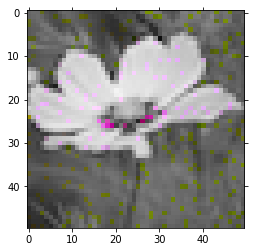

In [ ]:
#read in imgage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

img = mpimg.imread("/content/flower.png")
img = img[:,:,0:3]
m,n,_ = img.shape

np.random.seed(5)
known_ind = np.where(np.random.rand(m,n) >= 0.90)
# grayscale image
M = 0.299*img[:,:,0]+0.587*img[:,:,1]+0.114*img[:,:,2]
# known color values
R_known = img[:,:,0]
G_known = img[:,:,1]
B_known = img[:,:,2]
R_known = R_known[known_ind]
G_known = G_known[known_ind]
B_known = B_known[known_ind]

def save_img(filename, R,G,B):
  img = np.stack((np.array(R),np.array(G),np.array(B)), axis=2)
  # turn off ticks and labels of the figure
  plt.tick_params(
    axis='both', which='both', labelleft='off', labelbottom='off',
    bottom='off', top='off', right='off', left='off'
  )
  fig = plt.imshow(img)
  plt.savefig(filename,bbox_inches='tight',pad_inches=0.)

R_given = np.copy(M);
R_given[known_ind] = R_known;
G_given = np.copy(M);
G_given[known_ind] = G_known;
B_given = np.copy(M);
B_given[known_ind] = B_known;
save_img("flower_given.png", R_given, G_given, B_given)

In [ ]:
import cvxpy as cp
rows, cols, colors = img.shape
given = np.array([R_given.T,G_given.T,B_given.T]).T

variables = []
constraints = []
for i in range(colors):
    U = cp.Variable(shape=(rows, cols))
    variables.append(U)
    constraints.append(U[known_ind] == given[:, :, i][known_ind])
    constraints.append(U<=1)
    constraints.append(U>=0)
    
constraints.append(0.299*variables[0]+0.587*variables[1]+0.114*variables[2] == M)

prob = cp.Problem(cp.Minimize(cp.tv(*variables)), constraints)
prob.solve(verbose=True, solver=cp.ECOS) #'ECOS', 'SCS', or 'OSQP'.
print("optimal objective value: {}".format(prob.value))

optimal objective value: 341.96404500840214


(-0.5, 49.5, 49.5, -0.5)

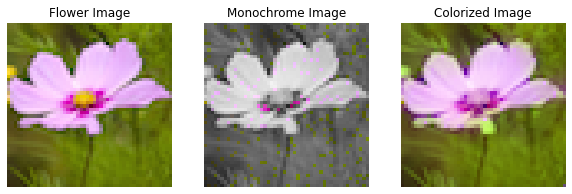

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

rec_arr = np.zeros((rows, cols, colors))
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value
rec_arr = np.clip(rec_arr, 0, 1)

fig, ax = plt.subplots(1, 3,figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title("Flower Image")
ax[0].axis('off')

ax[1].imshow(given)
ax[1].set_title("Monochrome Image")
ax[1].axis('off')

ax[2].imshow(rec_arr)
ax[2].set_title("Colorized Image")
ax[2].axis('off')


In [ ]:
import cvxpy as cvx

R = cvx.Variable(shape=(m,n))
G = cvx.Variable(shape=(m,n))
B = cvx.Variable(shape=(m,n))
constraints = [
  0.299*R + 0.587*G + 0.114*B == M,
  R[known_ind] == R_known,
  G[known_ind] == G_known,
  B[known_ind] == B_known,
  0 <= R, 0 <= G, 0 <= B,
  1 >= R, 1 >= G, 1 >= B,
]
optval = cvx.Problem(cvx.Minimize(cvx.tv(R,G,B)), constraints).solve()
print(optval)


341.96404500867686


# A 7.7

## relaxed A-optimal

In [1]:
import cvxpy as cp
import numpy as np

n = 5  # dimension
p = 20  # number of available types of measurements
m = 30  # total number of measurements to be carried out
V = np.random.randn(n,p)

In [2]:
lam = cp.Variable(p)
obj = 0
for k in range(n):
  e = np.zeros(shape = (n, 1))
  e[k] = 1
  obj += 1/m * cp.matrix_frac(e, V @ cp.diag(lam) @ V.T)
constraints = [cp.sum(lam)==1, cp.min(lam) >= 0]

prob = cp.Problem(cp.Minimize(obj),constraints)
prob.solve(solver = cp.CVXOPT)

print("The optimal value is", prob.value)

The optimal value is 0.17712785341013104


## discrete A-optimal

In [7]:
low_bnd = prob.value

m_rnd = cp.pos(np.round(m*lam.value,decimals=2))
print(sum(m_rnd.value) == m)

up_bnd = 0
for k in range(n):
  e = np.zeros(shape = (n, 1))
  e[k] = 1
  up_bnd += 1/m * cp.matrix_frac(e, V @ cp.diag(m_rnd/m) @ V.T)


gap = up_bnd - low_bnd
gap_value = gap.value
print ('The gap between the upper and the lower bounds is:', gap_value)

True
The gap between the upper and the lower bounds is: 4.594497815535448e-08


# A 7.21


In [66]:
import numpy as np
import scipy.linalg as la
from numpy.random import RandomState
from scipy import signal

# Parameters
M = 10;
T=200;
N = 3*T;
p = 0.2;
rn = RandomState(364)

beta_true = 2*rn.rand(M)-1
beta_true = beta_true/la.norm(beta_true,1)
x_true = (rn.rand(N) < p) *rn.randn(N)

y_shifted = np.zeros(N+M);
# Shift y by M, then generate y using AR model
for t in range(N):
    y_shifted[t+M] = x_true[t]+ np.sum(np.flipud(beta_true)*y_shifted[t+M-M:t+M])
# Only observe a length T subsequence.
y= y_shifted[1+T+M:1+T+T+M]
beta_true

array([-0.02661195, -0.1427229 , -0.11022044,  0.12165291, -0.17682919,
       -0.13401851, -0.04016229,  0.05618336,  0.0410527 , -0.15054575])

In [63]:
import cvxpy as cp
beta_1 = cp.Variable(shape=(M,1))
obj_1 = 0
for i in range(0,T-M-1):
  y_pre = beta_1.T*y[i+M:i:-1]
  obj_1+=cp.square(y[i+M+1]-y_pre)

prob_1 = cp.Problem(cp.Minimize(obj_1))
prob_1.solve()

48.65413037425698

In [75]:
import cvxpy as cp
beta_2 = cp.Variable(shape=(M,1))
obj_2 = 0
for i in range(0,T-M-1):
  y_pre = beta_2.T*y[i+M:i:-1]
  obj_2+=cp.abs(y[i+M+1]-y_pre)
obj_2 = obj_1+0.1*obj_2
prob_2 = cp.Problem(cp.Minimize(obj_2))
prob_2.solve()

52.187730968031445

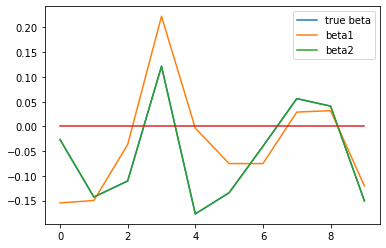

In [76]:
import matplotlib.pyplot as plt

plt.plot(range(10),beta_true,label="true beta")
plt.plot(range(10),beta_1.value,label="beta1")
plt.plot(range(10),beta_2.value,label="beta2")
plt.plot(range(10),np.zeros(10))
plt.legend()

In [79]:
print(beta_true)
print(beta_2.value.T)

[-0.02661195 -0.1427229  -0.11022044  0.12165291 -0.17682919 -0.13401851
 -0.04016229  0.05618336  0.0410527  -0.15054575]
[[-0.02661195 -0.1427229  -0.11022044  0.12165291 -0.17682919 -0.13401851
  -0.04016229  0.05618336  0.0410527  -0.15054575]]


# A 7.37

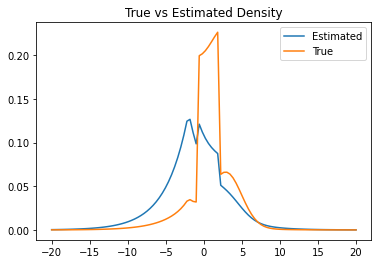

In [24]:
import cvxpy as cp
import numpy as np
from scipy.stats import norm, laplace, uniform
from matplotlib import pyplot as plt

# True weights for the underlying mixture
true_mixture_weights = [.3, .5, .2]
N = 100
k = 3

# This function generates N from the true mixture of distributions. 
# When you use this function to plot your estimated densities, 
# pass in the weights you obtain instead of the default parameters. 
def generate_samples(mixture_weights):
    np.random.seed(1)
    # Parameters for the distributions in our mixture: N(3, 2^2), U(-1, 2), L(-2, 3)
    samples = np.vstack([[np.random.normal(3, 2), 
                              np.random.uniform(-1, 2), 
                              np.random.laplace(-2, 3)] for _ in range(N)])
    indices = np.random.choice(list(range(len(mixture_weights))), p = mixture_weights, size = N)
    samples = np.take_along_axis(samples, indices[:, None], axis = 1)
    return samples.flatten()

# This function evaluates a set of univariate samples
# under the Gaussian, Uniform, and Laplace densities in the problem.
def evaluate_density(samples):
    # Parameters for the distributions in our mixture: N(3, 2^2), U(-1, 2), L(-2, 3)
    # Minor note: Scipy uniform.pdf expects the first argument as the start interval and the 
    # second as the length of interval, *not* the endpoint
    densities = [[norm.pdf(x, 3,2), 
                          uniform.pdf(x, -1, 3), 
                          laplace.pdf(x, -2, 3)] for x in samples]
    densities = np.array(densities)
    return densities

# This function takes as input the estimated mixture weights
# and generates a plot of both the estimated and true density
# by analytically evaluating the density at each point in a discretized
# interval [-20, 20]
def plot_estimated_and_true_density(estimated_mixture_weights):
    discretized_x = np.linspace(-20, 20, num=100)
    all_densities = evaluate_density(discretized_x)
    estimated_densities = all_densities @ estimated_mixture_weights
    true_densities = all_densities @ true_mixture_weights
    plt.plot(discretized_x, estimated_densities, label = "Estimated")
    plt.plot(discretized_x, true_densities, label = "True")
    plt.title("True vs Estimated Density")
    plt.legend()
    plt.show()

# The below two lines generate the samples and form the densities matrix.
# The densities matrix is of dimension N x k,
# where each row contains the evaluations of a datapoint under each density in the mixture.
samples = generate_samples(true_mixture_weights)
densities = evaluate_density(samples)

# Plot the true and estimated densities. 
# This currently plots with some placeholder incorrect values for lambda
# You should replace these when you estimate the lambdas
plot_estimated_and_true_density(np.array([.1, .1, .8]))

In [28]:
lmb = cp.Variable(shape=(k,1))
obj = -cp.sum(cp.log(lmb.T @ densities.T))
constraints = [sum(lmb)==1, lmb>=0]
prob = cp.Problem(cp.Minimize(obj),constraints)
prob.solve()

206.88181359033456

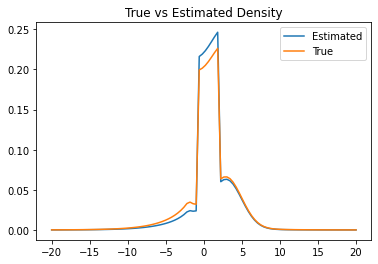

In [29]:
plot_estimated_and_true_density(lmb.value)

# A 6.5

In [39]:
import cvxpy as cp
import numpy as np
np.random.seed(0)
A = np.random.randn(100,30)
b = np.random.randn(100,1)

In [23]:
# l1.5
x = cp.Variable(shape=(30,1))
s = cp.Variable(shape=(100,1))
obj = cp.mixed_norm(s, 2, 3)
constraints = [s >= cp.abs(A*x-b)]
prob = cp.Problem(cp.Minimize(obj),constraints)
prob.solve()

4.848858246643649

In [49]:
# l1
x_1 = cp.Variable(shape=(30,1))
obj_1 = cp.norm(A*x_1-b,1)
prob_1 = cp.Problem(cp.Minimize(obj_1))
prob_1.solve()

66.15897931542277

In [50]:
# l2
x_2 = A/b

Text(0.5, 1.0, 'residuals of l2')

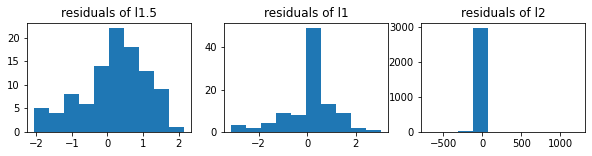

In [53]:
import matplotlib.pyplot as plt
r = A*x-b 
r = r.value.flatten().tolist()
r_1 = (A*x_1-b).value.flatten().tolist()
r_2 = (A*x_2-b).flatten().tolist()

fig, ax = plt.subplots(1, 3,figsize=(10, 2))
ax[0].hist(r)
ax[0].set_title("residuals of l1.5")

ax[1].hist(r_1)
ax[1].set_title("residuals of l1")

ax[2].hist(r_2)
ax[2].set_title("residuals of l2")